## Máster en Data Science - Series Temporales

# CES Models
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

En este notebook, se ha seleccionado el modelo exponencial complejo (CES, por sus siglas en inglés), una metodología innovadora que combina el poder de la descomposición exponencial con componentes complejos para capturar tendencias y estacionalidades en series temporales. Este modelo destaca por su capacidad para adaptarse a patrones no lineales y su flexibilidad para manejar series con alta variabilidad, lo que lo convierte en una herramienta prometedora para entender y predecir la evolución de la demanda de transporte público en Madrid.

Hasta el momento hemos probado modelos de predicción sencilla, modelos ARIMA, ETS y Theta, siendo estos dos últimos los que mejor se adaptan a la serie temporal proporcionando las predicciones más acertadas. Evaluaremos los modelos CES y comentaremos sus resultados.

In [10]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import Theta, FourTheta, StatsForecastAutoCES
from darts.metrics import mape, smape, rmse, mse
from darts import TimeSeries


import warnings
warnings.filterwarnings('ignore')

### Importación de datos

In [11]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [12]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [13]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## Modelo CES

Selecciona automáticamente el mejor modelo de Suavizado Exponencial Complejo (CES, por sus siglas en inglés) utilizando un criterio de información.
Por defecto, se utiliza el Criterio de Información de Akaike corregido ($AICc$), mientras que los modelos particulares se estiman mediante máxima verosimilitud.
Las ecuaciones del espacio de estados se pueden determinar en función de sus componentes:
- $𝑆$ para simple
- $𝑃$ para parcial
- $𝑍$ para optimizado
- $𝑁$ para omitido.

El parámetro de tipo de modelo define la clase de modelo CES:
- $𝑁$ para CES simple (sin estacionalidad).
- $𝑆$ para estacionalidad simple (CES con rezago).
- $𝑃$ para estacionalidad parcial (sin parte compleja).
- $𝐹$ para estacionalidad completa (CES con rezago y partes estacionales reales y complejas).

Si el componente se selecciona como $𝑍$, actúa como un marcador de posición para indicar que el modelo AutoCES debe determinar el mejor parámetro.

In [14]:
df_autobus_month = TimeSeries.from_series(df_autobus_month)
df_autobus_trim = TimeSeries.from_series(df_autobus_trim)
df_combined_month = TimeSeries.from_series(df_combined_month)
df_combined_trim = TimeSeries.from_series(df_combined_trim)
df_metro_month = TimeSeries.from_series(df_metro_month)
df_metro_trim = TimeSeries.from_series(df_metro_trim)

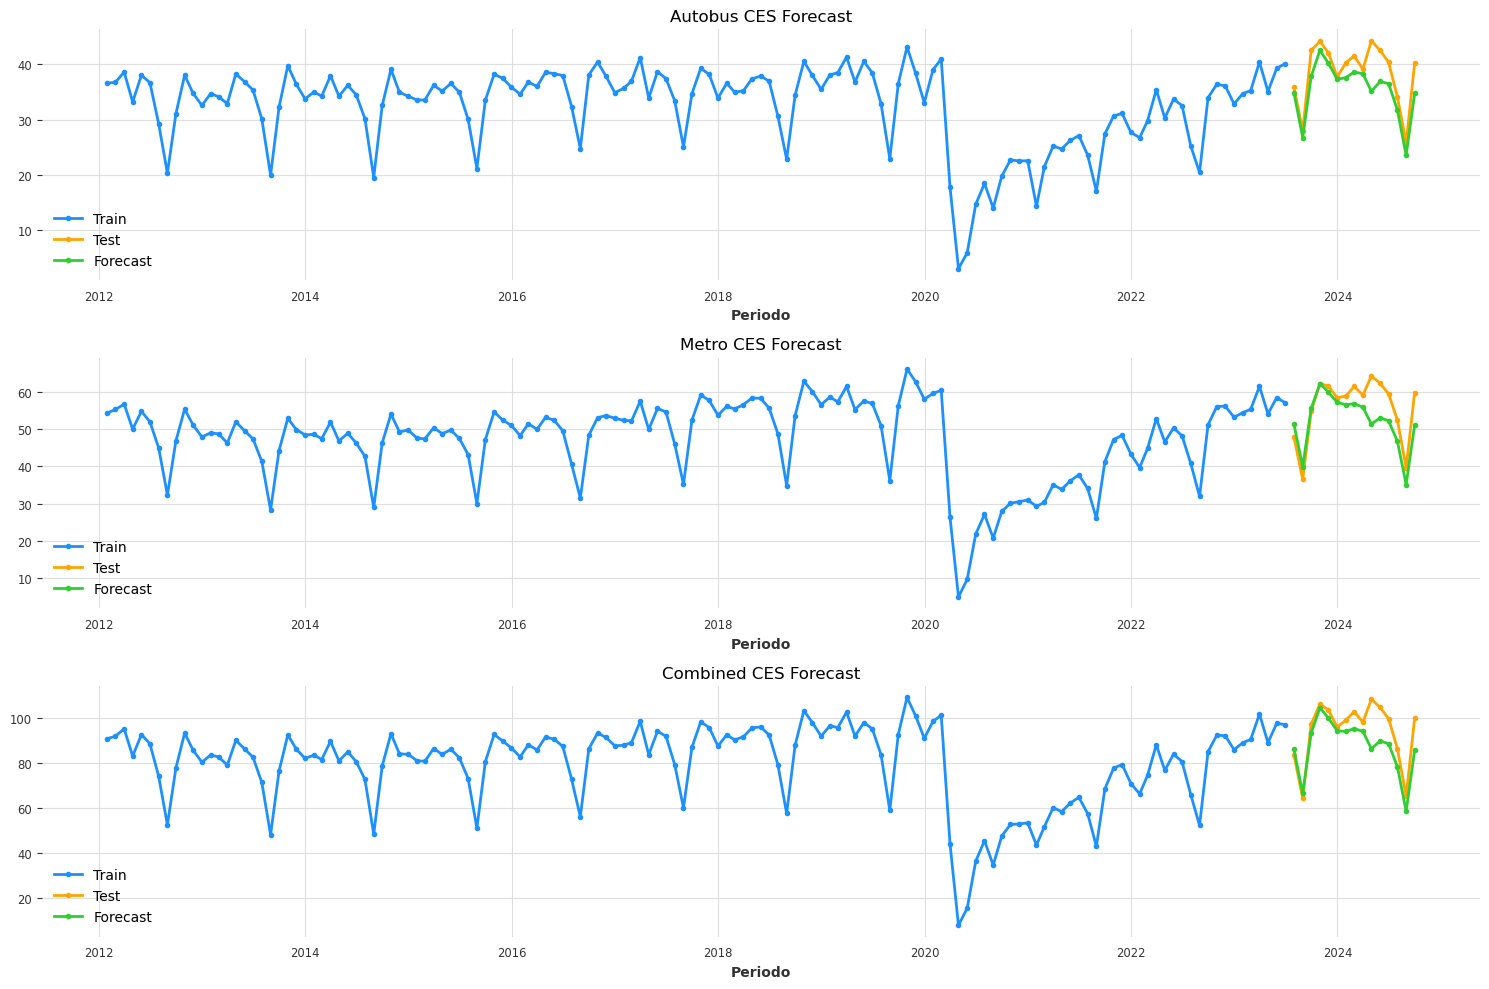

In [15]:
def plot_ces_forecast(df_autobus_month, df_metro_month, df_combined_month, test_size=15, seasonal_period=12):
    # Split data into train and test sets
    train_autobus = df_autobus_month[:-test_size]
    test_autobus = df_autobus_month[-test_size:]
    
    train_metro = df_metro_month[:-test_size]
    test_metro = df_metro_month[-test_size:]
    
    train_combined = df_combined_month[:-test_size]
    test_combined = df_combined_month[-test_size:]
    
    # Initialize and fit the CES model
    model_autobus = StatsForecastAutoCES(season_length=seasonal_period, model="Z")
    model_autobus.fit(train_autobus)
    forecast_autobus = model_autobus.predict(test_size)
    
    model_metro = StatsForecastAutoCES(season_length=seasonal_period, model="Z")
    model_metro.fit(train_metro)
    forecast_metro = model_metro.predict(test_size)
    
    model_combined = StatsForecastAutoCES(season_length=seasonal_period, model="Z")
    model_combined.fit(train_combined)
    forecast_combined = model_combined.predict(test_size)
    
    # Plot the results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    train_autobus.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
    test_autobus.plot(label='Test', color='orange', marker='o', markersize=3)
    forecast_autobus.plot(label='Forecast', color='limegreen', marker='o', markersize=3)
    plt.title('Autobus CES Forecast')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    train_metro.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
    test_metro.plot(label='Test', color='orange', marker='o', markersize=3)
    forecast_metro.plot(label='Forecast', color='limegreen', marker='o', markersize=3)
    plt.title('Metro CES Forecast')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    train_combined.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
    test_combined.plot(label='Test', color='orange', marker='o', markersize=3)
    forecast_combined.plot(label='Forecast', color='limegreen', marker='o', markersize=3)
    plt.title('Combined CES Forecast')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Llamada a la función con los argumentos especificados
plot_ces_forecast(df_autobus_month, df_metro_month, df_combined_month, test_size=15, seasonal_period=12)

Visualmente las predicciones de las series temporales mensuales parecen peores que las anteriormente evaluadas con los modelos ETS y Theta. Veremos sus métricas de evaluación.

In [16]:
def calculate_metrics(train_series, test_series, forecast_series):
    # Calculate metrics
    mse_value = mse(test_series, forecast_series)
    rmse_value = rmse(test_series, forecast_series)
    mape_value = mape(test_series, forecast_series)
    
    # Print metrics
    print(f'MSE: {mse_value}')
    print(f'RMSE: {rmse_value}')
    print(f'MAPE: {mape_value}')

# Ejemplo de uso con series mensuales
train_autobus = df_autobus_month[:-15]
test_autobus = df_autobus_month[-15:]
model_autobus = StatsForecastAutoCES(season_length=12, model="Z")
model_autobus.fit(train_autobus)
forecast_autobus = model_autobus.predict(len(test_autobus))

train_metro= df_metro_month[:-15]
test_metro = df_metro_month[-15:]
model_metro = StatsForecastAutoCES(season_length=12, model="Z")
model_metro.fit(train_autobus)
forecast_metro = model_metro.predict(len(test_metro))

train_combined= df_combined_month[:-15]
test_combined = df_combined_month[-15:]
model_combined = StatsForecastAutoCES(season_length=12, model="Z")
model_combined.fit(train_combined)
forecast_combined = model_combined.predict(len(test_combined))

print("Métricas para Autobús Mensual:")
calculate_metrics(train_autobus, test_autobus, forecast_autobus)
print("\nMétricas para Metro Mensual:")
calculate_metrics(train_metro, test_metro, forecast_metro)
print("\nMétricas para Combinado Mensual:")
calculate_metrics(train_combined, test_combined, forecast_combined)




Métricas para Autobús Mensual:
MSE: 14.439562354119598
RMSE: 3.79994241457941
MAPE: 7.717561356911075

Métricas para Metro Mensual:
MSE: 441.05416468417326
RMSE: 21.001289595740857
MAPE: 36.23961377818496

Métricas para Combinado Mensual:
MSE: 85.79427426559427
RMSE: 9.262519865867725
MAPE: 7.541811855156374


Las métricas de evaluación no son muy buenas si las comparamos con nuestros modelos anteriores. Por ahora los modelos ETS y Theta son los que mejores resultados han proporcionado.

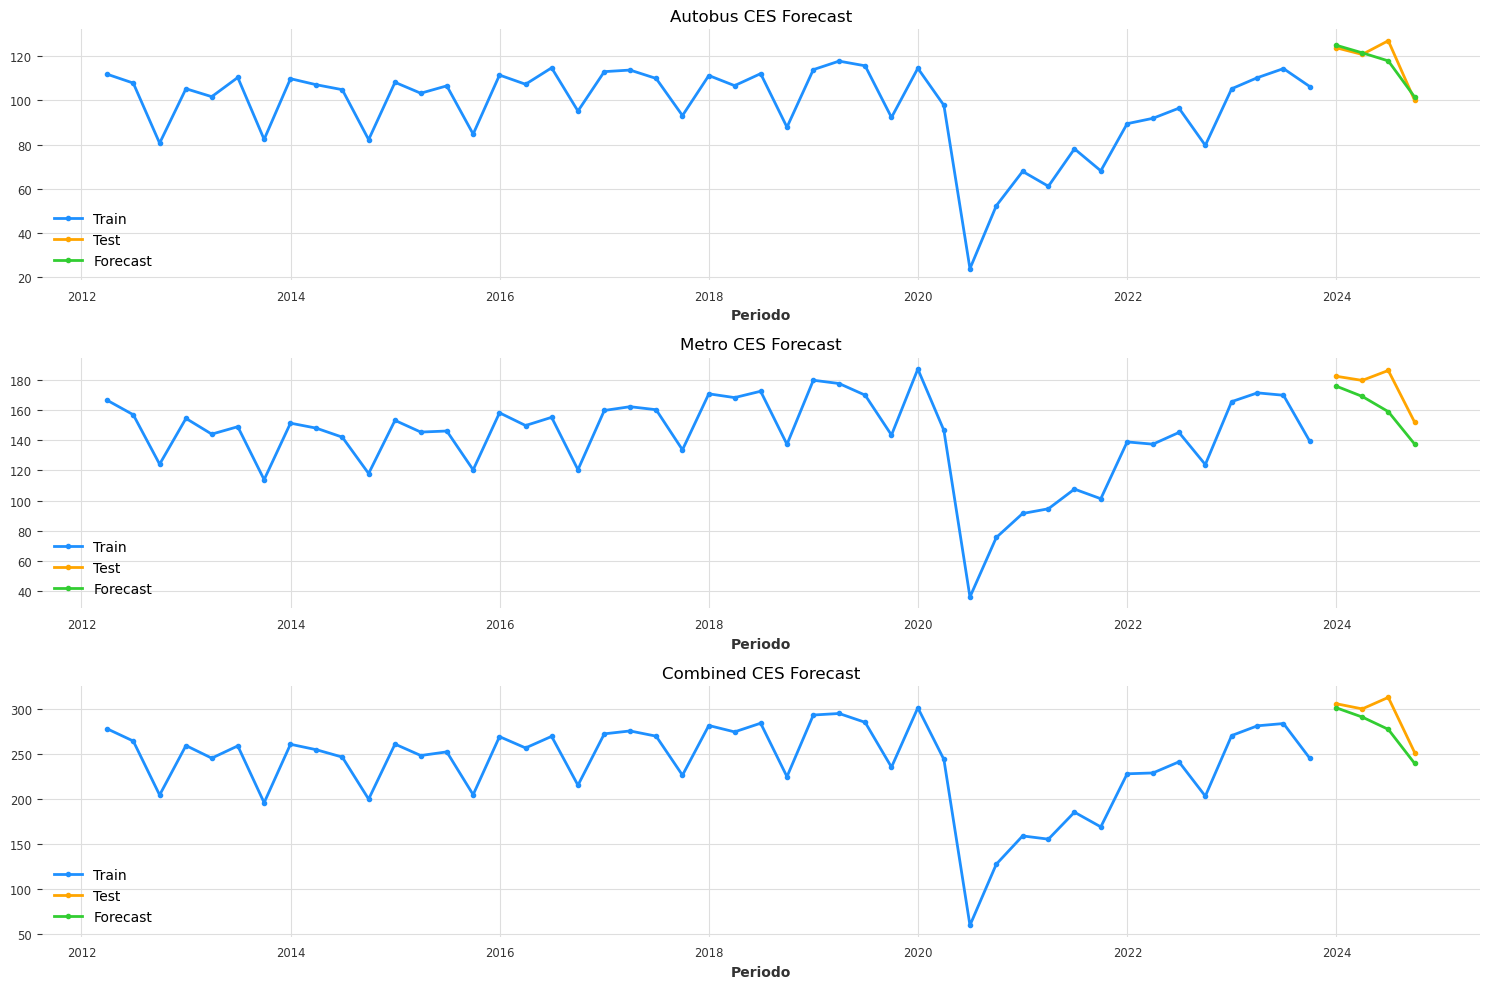

In [17]:
plot_ces_forecast(df_autobus_trim, df_metro_trim, df_combined_trim, test_size=4, seasonal_period=4)

Para la serie trimestral de los pasajeros del transporte público de Madrid las predicciones no parecen ser las mejores. Evaluaremos las métricas.

In [18]:
# Ejemplo de uso con series trimestrales
train_autobus_trim = df_autobus_trim[:-4]
test_autobus_trim = df_autobus_trim[-4:]
model_autobus_trim = StatsForecastAutoCES(season_length=4, model="Z")
model_autobus_trim.fit(train_autobus_trim)
forecast_autobus_trim = model_autobus_trim.predict(len(test_autobus_trim))

train_metro_trim = df_metro_trim[:-4]
test_metro_trim = df_metro_trim[-4:]
model_metro_trim = StatsForecastAutoCES(season_length=4, model="Z")
model_metro_trim.fit(train_metro_trim)
forecast_metro_trim = model_metro_trim.predict(len(test_metro_trim))

train_combined_trim = df_combined_trim[:-4]
test_combined_trim = df_combined_trim[-4:]
model_combined_trim = StatsForecastAutoCES(season_length=4, model="Z")
model_combined_trim.fit(train_combined_trim)
forecast_combined_trim = model_combined_trim.predict(len(test_combined_trim))

print("Métricas para Autobús Trimestral:")
calculate_metrics(train_autobus_trim, test_autobus_trim, forecast_autobus_trim)
print("\nMétricas para Metro Trimestral:")
calculate_metrics(train_metro_trim, test_metro_trim, forecast_metro_trim)
print("\nMétricas para Combinado Trimestral:")
calculate_metrics(train_combined_trim, test_combined_trim, forecast_combined_trim)

Métricas para Autobús Trimestral:
MSE: 21.840932813818966
RMSE: 4.673428379018873
MAPE: 2.549824797693235

Métricas para Metro Trimestral:
MSE: 276.37103350231314
RMSE: 16.624410771582646
MAPE: 8.411230479645505

Métricas para Combinado Trimestral:
MSE: 376.42191914393806
RMSE: 19.4015957885927
MAPE: 5.155781278270181


Poco que comentar, al igual que anteriormente, los modelos ETS y Theta parecen adaptarse mejor a las predicciones de este tipo de series temporales. Como punto de interés, mencionar que la predicción de la serie trimestral de autobús ha proporcionado una muy buenas métricas con un MAPE de tan solo un 2.54%.

***
## Conclusión CES

Los resultados de las predicciones obtenidas con los modelos CES, aunque razonables, no alcanzaron el nivel de precisión observado con los modelos ETS y Theta. Esto sugiere que, en el caso de las series temporales de pasajeros de autobús y metro de Madrid, los modelos CES pueden no ser la mejor opción para capturar patrones como la estacionalidad y las tendencias características de estos datos. Sin embargo, el modelo CES sigue siendo valioso por su enfoque innovador y su capacidad para manejar series con patrones no lineales o complejos, lo que podría ser útil en otros contextos o series con características diferentes. En comparación, los modelos ETS y Theta demostraron ser más efectivos y confiables en este escenario, reafirmando su adecuación para series temporales con patrones más regulares y definidos.